In [38]:
#! pip install -r ./requirements.txt
#code working only for older version of qiskit as given in requirements
import circgenerator as cg
from checksfinder import get_error_mitig_circ

from qiskit import QuantumCircuit, transpile, ClassicalRegister
# from qiskit_aer import AerSimulator
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_histogram

from qiskit.providers.aer.noise import depolarizing_error, NoiseModel
from matplotlib import pyplot as plt

In [39]:
#simulate circuit given noise model
def simulate(circ, noise_model, num_shots):
    circ_with_measurement = circ.copy('circ_with_measurement')
    circ_with_measurement.measure_all()
    backend = AerSimulator(method='statevector', noise_model=noise_model)
    compiled_circuit = transpile(circ_with_measurement, backend, optimization_level=0)
    job = backend.run(compiled_circuit, shots=num_shots)
    count = job.result().get_counts(circ_with_measurement)
    return count

In [40]:
#simulate circuit with PCS given number of levells of PCS and noise model
def simulate_with_pcs(circ, noise_model, levels, num_shots):
    n_qubits = circ.num_qubits
    qem_qasm = get_error_mitig_circ(circ.qasm(), levels)
    qem_circ = QuantumCircuit.from_qasm_str(qem_qasm)
    
    crs = ClassicalRegister(n_qubits)
    qem_circ.add_register(crs)
    for i, qubit in enumerate(qem_circ.qubits[:n_qubits]):
        qem_circ.measure(qubit, crs[i])

    backend = AerSimulator(method='statevector', noise_model=noise_model)
    compiled_circuit = transpile(qem_circ, backend, optimization_level=0)
    job = backend.run(compiled_circuit, shots=num_shots)
    count = job.result().get_counts(qem_circ)

    #post selection of results
    count_filtered = {}
    for i in count.keys():
        if i[n_qubits+1:] == '0'*levels:
            count_filtered[i[:n_qubits]]=count[i]
    
    return count_filtered

        ┌───┐     ┌─────┐┌───┐     ┌───┐┌───┐
q346_0: ┤ X ├──■──┤ Sdg ├┤ H ├──■──┤ H ├┤ S ├
        ├───┤┌─┴─┐├─────┤├───┤┌─┴─┐└───┘└───┘
q346_1: ┤ S ├┤ X ├┤ Sdg ├┤ H ├┤ X ├──────────
        └───┘└───┘└─────┘└───┘└───┘          


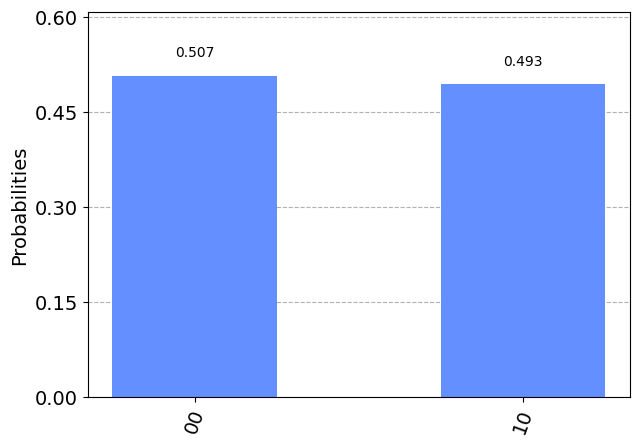

In [43]:
n_qubits=2
n_cnots = 2

circ = cg.generate_a_random_clifford_circuit(n_qubits, n_cnots)
print(circ)
plot_histogram(simulate(circ, None, 10000))


*Single qubit depolarizing error*

In [50]:
dep_err_channel = depolarizing_error(0.1, 1)
noise_model_dep_err = NoiseModel()
noise_model_dep_err.add_all_qubit_quantum_error(dep_err_channel, 'h')
print(noise_model_dep_err)
num_shots = 10000

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx']
  Instructions with noise: ['h']
  All-qubits errors: ['h']


running...
searching...
terminating...
        ░ ┌─────┐     ┌───┐┌───┐ ░ ┌───┐     ┌─────┐┌───┐     ┌───┐┌───┐ ░ »
  a_0: ─░─┤ Sdg ├─────┤ X ├┤ S ├─░─┤ X ├──■──┤ Sdg ├┤ H ├──■──┤ H ├┤ S ├─░─»
        ░ └─────┘┌───┐└─┬─┘└───┘ ░ ├───┤┌─┴─┐├─────┤├───┤┌─┴─┐└───┘└───┘ ░ »
  a_1: ─░────────┤ X ├──┼────────░─┤ S ├┤ X ├┤ Sdg ├┤ H ├┤ X ├───────────░─»
        ░  ┌───┐ └─┬─┘  │        ░ └───┘└───┘└─────┘└───┘└───┘           ░ »
    b: ─░──┤ H ├───■────■────────░───────────────────────────────────────░─»
        ░  └───┘                 ░                                       ░ »
c22: 1/════════════════════════════════════════════════════════════════════»
                                                                           »
«       ┌───┐      ░    
«  a_0: ┤ X ├──────░────
«       └─┬─┘      ░    
«  a_1: ──┼────────░────
«         │  ┌───┐ ░ ┌─┐
«    b: ──■──┤ H ├─░─┤M├
«            └───┘ ░ └╥┘
«c22: 1/══════════════╩═
«                     0 
total execution time 0.5009980201721191
don

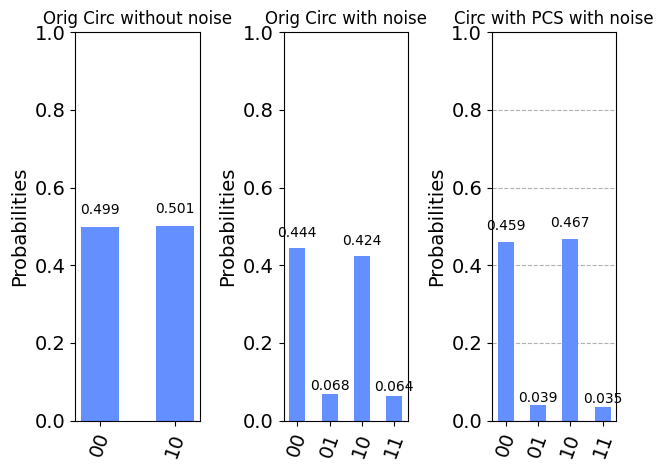

In [51]:
noise_model = noise_model_dep_err
count = simulate_with_pcs(circ, noise_model, 1, num_shots)
print('Percentage of shots used in PCS: ', sum(count.values())/num_shots)

fig, axs = plt.subplots(1, 3)
plot_histogram(simulate(circ, None, num_shots), ax=axs[0]) 
axs[0].set_title('Orig Circ without noise')
plot_histogram(simulate(circ, noise_model, num_shots), ax=axs[1])
axs[1].set_title('Orig Circ with noise')
plot_histogram(count, ax=axs[2])
axs[2].set_title('Circ with PCS with noise')
plt.setp(axs, ylim=(0,1))
fig.tight_layout()

*2 qubit depolarizing error*

In [52]:
dep_err_channel = depolarizing_error(0.2, 2)
print(dep_err_channel)
noise_model_dep_err_multi = NoiseModel()
noise_model_dep_err_multi.add_all_qubit_quantum_error(dep_err_channel, 'cx')
print(noise_model_dep_err_multi)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.8125000000000006, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(II) │
q_1: ┤1           ├
     └────────────┘
  P(1) = 0.01250000000000001, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(IX) │
q_1: ┤1           ├
     └────────────┘
  P(2) = 0.01250000000000001, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(IY) │
q_1: ┤1           ├
     └────────────┘
  P(3) = 0.01250000000000001, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(IZ) │
q_1: ┤1           ├
     └────────────┘
  P(4) = 0.01250000000000001, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(XI) │
q_1: ┤1           ├
     └────────────┘
  P(5) = 0.01250000000000001, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(XX) │
q_1: ┤1           ├
     └────────────┘
  P(6) = 0.01250000000000001, Circuit = 
     ┌────────────┐
q_0: ┤0           ├
     │  Pauli(XY) │
q_1: ┤1     

running...
searching...
terminating...
        ░ ┌─────┐                           ┌───┐┌───┐ ░ ┌───┐     ┌─────┐┌───┐»
  a_0: ─░─┤ Sdg ├───────────────────────────┤ X ├┤ S ├─░─┤ X ├──■──┤ Sdg ├┤ H ├»
        ░ └┬───┬┘┌───┐┌───┐┌─────┐┌───┐┌───┐└─┬─┘└───┘ ░ ├───┤┌─┴─┐├─────┤├───┤»
  a_1: ─░──┤ H ├─┤ X ├┤ H ├┤ Sdg ├┤ X ├┤ S ├──┼────────░─┤ S ├┤ X ├┤ Sdg ├┤ H ├»
        ░  ├───┤ └─┬─┘└───┘└─────┘└─┬─┘└───┘  │        ░ └───┘└───┘└─────┘└───┘»
  b_0: ─░──┤ H ├───┼────────────────■─────────■────────░───────────────────────»
        ░  ├───┤   │                                   ░                       »
  b_1: ─░──┤ H ├───■───────────────────────────────────░───────────────────────»
        ░  └───┘                                       ░                       »
c28: 2/════════════════════════════════════════════════════════════════════════»
                                                                               »
«            ┌───┐┌───┐ ░ ┌─────┐┌───┐┌───┐┌───┐┌───┐┌───┐ ░       
« 

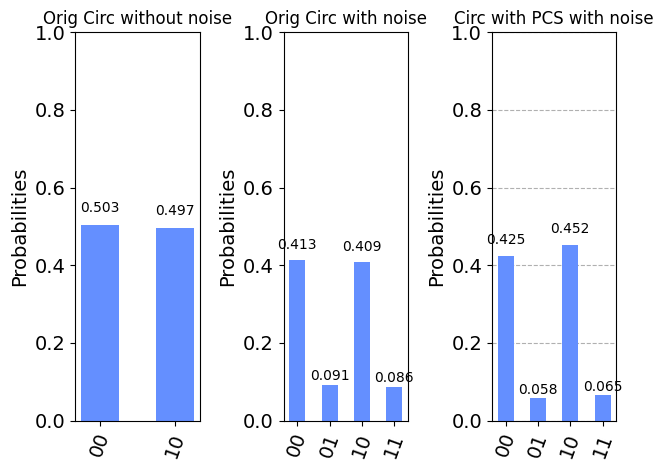

In [55]:
num_shots = 10000
noise_model = noise_model_dep_err_multi

count = simulate_with_pcs(circ, noise_model, 2, num_shots)
print('Percentage of shots used in PCS: ', sum(count.values())/num_shots)

fig, axs = plt.subplots(1, 3)
plot_histogram(simulate(circ, None, num_shots), ax=axs[0]) 
axs[0].set_title('Orig Circ without noise')
plot_histogram(simulate(circ, noise_model, num_shots), ax=axs[1])
axs[1].set_title('Orig Circ with noise')
plot_histogram(count, ax=axs[2])
axs[2].set_title('Circ with PCS with noise')
plt.setp(axs, ylim=(0,1))
fig.tight_layout()

In [56]:
n_qubits=2

rep = 1
# circ = cg.generate_a_random_clifford_circuit(n_qubits, n_cnots, 0)
circ = QuantumCircuit(n_qubits)
for i in range(rep):
    # circ.h(0)
    circ.cnot(0, 1)
    # circ.x(2)
print(circ)

          
q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘


running...


searching...
terminating...
        ░           ┌───┐ ░       ░ ┌───┐      ░    
  a_0: ─░───────────┤ X ├─░───■───░─┤ X ├──────░────
        ░      ┌───┐└─┬─┘ ░ ┌─┴─┐ ░ └─┬─┘      ░    
  a_1: ─░──────┤ X ├──┼───░─┤ X ├─░───┼────────░────
        ░ ┌───┐└─┬─┘  │   ░ └───┘ ░   │  ┌───┐ ░ ┌─┐
    b: ─░─┤ H ├──■────■───░───────░───■──┤ H ├─░─┤M├
        ░ └───┘           ░       ░      └───┘ ░ └╥┘
c34: 1/═══════════════════════════════════════════╩═
                                                  0 
total execution time 0.31090831756591797
done
Percentage of shots used in PCS:  0.7017


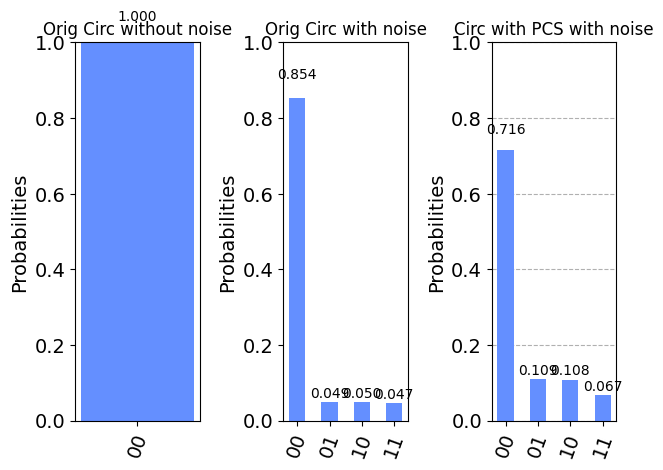

In [59]:
num_shots = 10000
noise_model = noise_model_dep_err_multi

count = simulate_with_pcs(circ, noise_model, 1, num_shots)
print('Percentage of shots used in PCS: ', sum(count.values())/num_shots)

fig, axs = plt.subplots(1, 3)
plot_histogram(simulate(circ, None, num_shots), ax=axs[0]) 
axs[0].set_title('Orig Circ without noise')
plot_histogram(simulate(circ, noise_model, num_shots), ax=axs[1])
axs[1].set_title('Orig Circ with noise')
plot_histogram(count, ax=axs[2])
axs[2].set_title('Circ with PCS with noise')
plt.setp(axs, ylim=(0,1))
fig.tight_layout()

Open problems:

Single CNOT error not reduced by PCS which is wierd.

In qiskit, depol applied error before the unitart which might be probamatic..
Try applying error after unitary as in the paper

